# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import hydra
from omegaconf import OmegaConf, open_dict
%load_ext autoreload
%autoreload 2

import breaching
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [2]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=modern'])
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
          
device = torch.device(f'cuda:2') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_imagenet with server type honest_but_curious.


{'device': device(type='cuda', index=2), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [3]:
cfg.case.data.partition="unique-class"
cfg.case.user.user_idx = 0
cfg.case.model='resnet18'

cfg.case.user.provide_buffers = True
cfg.case.server.provide_public_buffers = False

cfg.attack.optim.warmup = 50
cfg.attack.optim.step_size = 0.1
cfg.attack.regularization.deep_inversion.scale = 1
cfg.attack.objective.scale=0.0
# # cfg.attack.regularization.features.scale = 0.0

cfg.attack.init = "patterned-4"

### Instantiate all parties

In [4]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Model architecture resnet18 loaded with 11,380,173 parameters and 9,620 buffers.
Overall this is a data ratio of      76:1 for target shape [1, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 1

    Threat model:
    User provides labels: False
    User provides buffers: True
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 0
    
        
Server (of type HonestServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: resnet18
        model state: default
        public buffers: False

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: invertinggradients

    Objective: Cosine Similarity with scale=0.0 and task reg=0.0
    Regularizers: Total Variation, scale=0.1. p=2 q=0.5. Color TV: double oppponents
       

### Simulate an attacked FL protocol

True user data is returned only for analysis

In [5]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  
# [(g.mean(), g.std()) for g in shared_data['gradients'][0]]

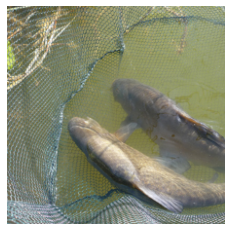

In [6]:
user.plot(true_user_data)

### Reconstruct user data:

In [7]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], 
                                                      server.secrets, dryrun=cfg.dryrun)

Recovered labels [0] through strategy bias-corrected.
| It: 1 | Rec. loss: 429.4643 |  Task loss: 5.7696 | T: 0.11s
| It: 1001 | Rec. loss: 13.1535 |  Task loss: 7.8587 | T: 62.22s
| It: 2001 | Rec. loss: 11.8425 |  Task loss: 8.2815 | T: 54.77s
| It: 3001 | Rec. loss: 11.6797 |  Task loss: 7.2869 | T: 54.59s
| It: 4001 | Rec. loss: 11.9249 |  Task loss: 7.5221 | T: 54.72s
| It: 5001 | Rec. loss: 10.4551 |  Task loss: 7.5645 | T: 54.61s
| It: 6001 | Rec. loss: 9.9835 |  Task loss: 7.5351 | T: 54.75s
| It: 7001 | Rec. loss: 8.9177 |  Task loss: 7.2807 | T: 54.64s
| It: 8001 | Rec. loss: 8.1154 |  Task loss: 7.1822 | T: 54.67s
| It: 9001 | Rec. loss: 6.7390 |  Task loss: 5.5532 | T: 54.56s
| It: 10001 | Rec. loss: 5.7018 |  Task loss: 5.5331 | T: 54.72s
| It: 11001 | Rec. loss: 5.4006 |  Task loss: 6.7808 | T: 54.78s
| It: 12001 | Rec. loss: 4.0287 |  Task loss: 6.9720 | T: 54.61s
| It: 13001 | Rec. loss: 3.6857 |  Task loss: 6.8803 | T: 54.64s
| It: 14001 | Rec. loss: 3.1925 |  Task los

In [8]:
#How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

METRICS: | MSE: 0.0408 | PSNR: 13.89 | FMSE: nan | LPIPS: 0.69|
 R-PSNR: 15.04 | IIP-pixel: 100.00% | SSIM: 0.2950 | max R-PSNR: 15.04 | max SSIM: 0.2950 | Label Acc: 100.00%


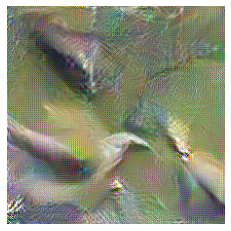

In [9]:
user.plot(reconstructed_user_data)